In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import style
import seaborn as sns
sns.set_style('whitegrid')

from sklearn.model_selection import train_test_split, cross_val_predict, cross_val_score
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.metrics import precision_score, recall_score, accuracy_score, roc_auc_score, roc_curve, auc, f1_score
import time
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
%matplotlib inline

In [2]:
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import SGDClassifier
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression

In [3]:
def roc_auc(pred, act, plot=True, label = "curve"):
    prob = pred/pred.max() #normalize
    fpr, tpr, threshold = roc_curve(act, prob, drop_intermediate=True)    
    a = auc(fpr, tpr)

    if plot:
        plt.scatter(x=fpr, y=tpr, color='navy')
        rcolor = tuple(np.random.rand(3,1)[:,0])
        plt.plot(fpr, tpr, c=rcolor, lw=2, label=label + ' (AUC = %0.3f)' % a)
        plt.plot([0, 1], [0, 1], color='navy', lw=1, linestyle='--')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('ROC Curve')
        plt.legend(loc="lower right")
        plt.show()

    return a

In [4]:
df = pd.read_csv('df_train2.csv')
test = pd.read_csv('df_test2.csv')
df.shape

(51759, 82)

In [5]:
test.shape

(10013, 82)

In [6]:
# Create X and y for train and test sets 
X = df.drop('readmitted', axis=1)
y = df['readmitted']

X_test = test.drop('readmitted', axis=1)
y_test = test['readmitted']

In [7]:
# Create test train splits for model training
X_train, X_dev, y_train, y_dev = train_test_split(X, y, test_size=0.20, random_state=42)

In [8]:
X_train.head()

,age,time_in_hospital,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_emergency,number_inpatient,diag_2,diag_3,...,A1Cresult_0,A1Cresult_1,diag_1_1.0,diag_1_2.0,diag_1_3.0,diag_1_4.0,diag_1_5.0,diag_1_6.0,diag_1_7.0,diag_1_8.0
40889,7,-0.438603,-0.351409,-0.809310,-0.807456,0.663873,-0.205982,-0.329314,1.0,1.0,...,0,0,0,0,0,1,0,0,0,0
16728,6,-0.099625,-0.200446,0.902949,0.277594,-0.264763,-0.205982,-0.329314,4.0,4.0,...,0,0,0,0,0,0,0,0,0,0
6730,6,0.578332,-0.099805,-0.809310,-0.807456,-0.264763,-0.205982,-0.329314,4.0,1.0,...,0,0,0,0,1,0,0,0,0,0
17005,8,-0.438603,0.403402,-0.238557,-0.807456,-0.264763,-0.205982,-0.329314,2.0,2.0,...,0,0,0,0,0,0,0,0,0,1
48036,8,-1.116561,-1.156541,-0.238557,-0.445773,-0.264763,-0.205982,-0.329314,8.0,2.0,...,0,0,1,0,0,0,0,0,0,0


#### Resample from train dataset to address imbalance using SMOTE

In [9]:
from imblearn.over_sampling import SMOTE
from collections import Counter
print('Original dataset shape {}'.format(Counter(y_train)))
sm = SMOTE(random_state=42)
X_train_new, y_train_new = sm.fit_sample(X_train, y_train)
print('New dataset shape {}'.format(Counter(y_train_new)))

Original dataset shape Counter({0: 37885, 1: 3522})
New dataset shape Counter({0: 37885, 1: 37885})


In [10]:
from imblearn.under_sampling import RandomUnderSampler
print('Original dataset shape {}'.format(Counter(y_train)))
sm2 = RandomUnderSampler(random_state=42)
X_train_new2, y_train_new2 = sm2.fit_sample(X_train, y_train)
print('New dataset shape {}'.format(Counter(y_train_new2)))

Original dataset shape Counter({0: 37885, 1: 3522})
New dataset shape Counter({0: 3522, 1: 3522})


#### Train Models with default parameters

In [11]:
xgb = XGBClassifier(n_estimators=100)
training_start = time.perf_counter()
xgb.fit(X_train_new, y_train_new)
training_end = time.perf_counter()
prediction_start = time.perf_counter()
preds = xgb.predict(X_dev.values)
prediction_end = time.perf_counter()
acc = accuracy_score(y_dev, preds)
pre = precision_score(y_dev, preds)
rec = recall_score(y_dev, preds)
AUC = roc_auc_score(y_dev, preds)
xgb_train_time = training_end-training_start
xgb_prediction_time = prediction_end-prediction_start

print("Accuracy: {:.4%}".format(acc))
print("Precision: {:.4%}".format(pre))
print("Recall: {:.4%}".format(rec))
print("AUC: {}".format(AUC))
print("Time consumed for training: %4.3f" % (xgb_train_time))
print("Time consumed for train-test prediction: %6.5f seconds" % (xgb_prediction_time))

Accuracy: 91.3833%
Precision: 0.0000%
Recall: 0.0000%
AUC: 0.5
Time consumed for training: 33.838
Time consumed for train-test prediction: 0.05698 seconds


/usr/local/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


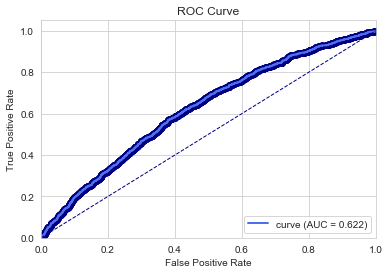

0.621854172394505

In [12]:
pred = xgb.predict_proba(X_dev.values)[:,1]
fpr, tpr, threshold = roc_curve(y_dev, pred, drop_intermediate=True)    
df_res = pd.DataFrame(data={'fpr':fpr, 'tpr':tpr, 'threshold':threshold})
df_res = df_res[['threshold','fpr','tpr']]
auc(fpr, tpr)
t=y.value_counts()[1]/y.value_counts().sum()
f1_score(y_dev, pred>t)
accuracy_score(y_dev, pred>t)

roc_auc(pred, y_dev)

In [14]:
prediction_start2 = time.perf_counter()
preds2 = xgb.predict(X_test.values)
prediction_end2 = time.perf_counter()
acc = accuracy_score(y_test, preds2)
pre = precision_score(y_test, preds2)
rec = recall_score(y_test, preds2)
AUC = roc_auc_score(y_test, preds2)
xgb_prediction_time2 = prediction_end2-prediction_start2

print("Accuracy: {:.4%}".format(acc))
print("Precision: {:.4%}".format(pre))
print("Recall: {:.4%}".format(rec))
print("AUC: {}".format(AUC))
print("Time consumed for test prediction: %6.5f seconds" % (xgb_prediction_time))

Accuracy: 95.3960%
Precision: 0.0000%
Recall: 0.0000%
AUC: 0.5
Time consumed for test prediction: 0.05698 seconds


/usr/local/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


In [17]:
training_start = time.perf_counter()
xgb.fit(X_train_new2, y_train_new2)
training_end = time.perf_counter()
prediction_start = time.perf_counter()
preds = xgb.predict(X_dev.values)
prediction_end = time.perf_counter()
acc = accuracy_score(y_dev, preds)
pre = precision_score(y_dev, preds)
rec = recall_score(y_dev, preds)
AUC = roc_auc_score(y_dev, preds)
xgb_train_time = training_end-training_start
xgb_prediction_time = prediction_end-prediction_start

print("Accuracy: {:.4%}".format(acc))
print("Precision: {:.4%}".format(pre))
print("Recall: {:.4%}".format(rec))
print("AUC: {}".format(AUC))
print("Time consumed for training: %4.3f" % (xgb_train_time))
print("Time consumed for prediction: %6.5f seconds" % (xgb_prediction_time))

Accuracy: 59.8532%
Precision: 12.0818%
Recall: 58.2960%
AUC: 0.5914798206278027
Time consumed for training: 2.989
Time consumed for prediction: 0.05495 seconds


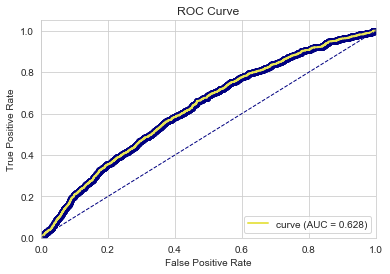

0.627802216554954

In [18]:
pred = xgb.predict_proba(X_dev.values)[:,1]
fpr, tpr, threshold = roc_curve(y_dev, pred, drop_intermediate=True)    
df_res = pd.DataFrame(data={'fpr':fpr, 'tpr':tpr, 'threshold':threshold})
df_res = df_res[['threshold','fpr','tpr']]
auc(fpr, tpr)
t=y.value_counts()[1]/y.value_counts().sum()
f1_score(y_dev, pred>t)
accuracy_score(y_dev, pred>t)

roc_auc(pred, y_dev)

In [16]:
rfc = RandomForestClassifier(n_estimators=100)
training_start = time.perf_counter()
rfc.fit(X_train_new, y_train_new)
training_end = time.perf_counter()
prediction_start = time.perf_counter()
preds = rfc.predict(X_dev)
prediction_end = time.perf_counter()
acc = accuracy_score(y_dev, preds)
pre = precision_score(y_dev, preds)
rec = recall_score(y_dev, preds)
AUC = roc_auc_score(y_dev, preds)
rfc_train_time = training_end-training_start
rfc_prediction_time = prediction_end-prediction_start

print("Accuracy: {:.4%}".format(acc))
print("Precision: {:.4%}".format(pre))
print("Recall: {:.4%}".format(rec))
print("AUC: {}".format(AUC))
print("Time consumed for training: %4.3f seconds" % (rfc_train_time))
print("Time consumed for prediction: %6.5f seconds" % (rfc_prediction_time))

Accuracy: 91.3833%
Precision: 0.0000%
Recall: 0.0000%
AUC: 0.5
Time consumed for training: 16.667 seconds
Time consumed for prediction: 0.33956 seconds


/usr/local/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


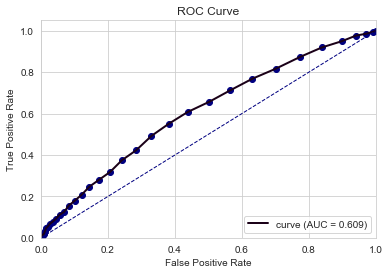

0.6091338678789143

In [14]:
pred = rfc.predict_proba(X_dev.values)[:,1]
fpr, tpr, threshold = roc_curve(y_dev, pred, drop_intermediate=True)    
df_res = pd.DataFrame(data={'fpr':fpr, 'tpr':tpr, 'threshold':threshold})
df_res = df_res[['threshold','fpr','tpr']]
auc(fpr, tpr)
t=y.value_counts()[1]/y.value_counts().sum()
f1_score(y_dev, pred>t)
accuracy_score(y_dev, pred>t)

roc_auc(pred, y_dev)

In [15]:
rfc = RandomForestClassifier(n_estimators=100)
training_start = time.perf_counter()
rfc.fit(X_train_new2, y_train_new2)
training_end = time.perf_counter()
prediction_start = time.perf_counter()
preds = rfc.predict(X_dev)
prediction_end = time.perf_counter()
acc = accuracy_score(y_dev, preds)
pre = precision_score(y_dev, preds)
rec = recall_score(y_dev, preds)
AUC = roc_auc_score(y_dev, preds)
rfc_train_time = training_end-training_start
rfc_prediction_time = prediction_end-prediction_start

print("Accuracy: {:.4%}".format(acc))
print("Precision: {:.4%}".format(pre))
print("Recall: {:.4%}".format(rec))
print("AUC: {}".format(AUC))
print("Time consumed for training: %4.3f seconds" % (rfc_train_time))
print("Time consumed for prediction: %6.5f seconds" % (rfc_prediction_time))

Accuracy: 57.6990%
Precision: 11.7905%
Recall: 60.3139%
AUC: 0.5888316631746604
Time consumed for training: 1.069 seconds
Time consumed for prediction: 0.18474 seconds


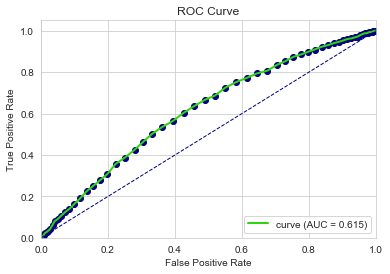

0.6147225988111378

In [16]:
pred = rfc.predict_proba(X_dev.values)[:,1]
fpr, tpr, threshold = roc_curve(y_dev, pred, drop_intermediate=True)    
df_res = pd.DataFrame(data={'fpr':fpr, 'tpr':tpr, 'threshold':threshold})
df_res = df_res[['threshold','fpr','tpr']]
auc(fpr, tpr)
t=y.value_counts()[1]/y.value_counts().sum()
f1_score(y_dev, pred>t)
accuracy_score(y_dev, pred>t)

roc_auc(pred, y_dev)

In [15]:
svc = SVC(probability = True)
training_start = time.perf_counter()
svc.fit(X_train, y_train)
training_end = time.perf_counter()
prediction_start = time.perf_counter()
preds = svc.predict(X_dev)
prediction_end = time.perf_counter()
acc = accuracy_score(y_dev, preds)
pre = precision_score(y_dev, preds)
rec = recall_score(y_dev, preds)
AUC = roc_auc_score(y_dev, preds)
svc_train_time = training_end-training_start
svc_prediction_time = prediction_end-prediction_start

print("Accuracy: {:.4%}".format(acc))
print("Precision: {:.4%}".format(pre))
print("Recall: {:.4%}".format(rec))
print("AUC: {}".format(AUC))
print("Time consumed for training: %4.3f seconds" % (svc_train_time))
print("Time consumed for prediction: %6.5f seconds" % (svc_prediction_time))

/usr/local/lib/python3.7/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


Accuracy: 91.3833%
Precision: 0.0000%
Recall: 0.0000%
AUC: 0.5
Time consumed for training: 5412.879 seconds
Time consumed for prediction: 40.79197 seconds


/usr/local/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


/usr/local/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


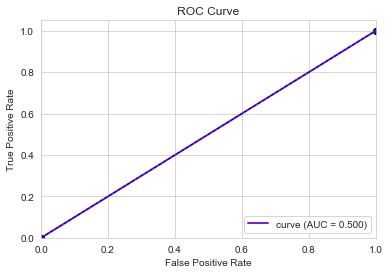

0.49994714587737843

In [16]:
pred = svc.predict_proba(X_dev.values)[:,1]
fpr, tpr, threshold = roc_curve(y_dev, pred, drop_intermediate=True)    
df_res = pd.DataFrame(data={'fpr':fpr, 'tpr':tpr, 'threshold':threshold})
df_res = df_res[['threshold','fpr','tpr']]
auc(fpr, tpr)
t=y.value_counts()[1]/y.value_counts().sum()
f1_score(y_dev, pred>t)
accuracy_score(y_dev, pred>t)

roc_auc(pred, y_dev)

In [ ]:
xgb = XGBClassifier(silent=False, 
                      scale_pos_weight=1,
                      learning_rate=0.01,  
                      colsample_bytree = 0.4,
                      subsample = 0.9,
                      objective='binary:logistic', 
                      n_estimators=1000, 
                      reg_alpha = 0.3,
                      max_depth=4, 
                      gamma=10)
eval_set = [(X_train_new, y_train_new), (X_dev, y_dev)]
eval_metric = ["auc","error"]
%time xgb.fit(X_train_new, y_train_new, eval_metric=eval_metric, eval_set=eval_set, verbose=True)

In [ ]:
pred = xgb.predict_proba(X_dev)[:,1]
fpr, tpr, threshold = roc_curve(y_dev, pred, drop_intermediate=True)    
df_res = pd.DataFrame(data={'fpr':fpr, 'tpr':tpr, 'threshold':threshold})
df_res = df_res[['threshold','fpr','tpr']]
auc(fpr, tpr)
t=y.value_counts()[1]/y.value_counts().sum()
f1_score(y_dev, pred>t)
accuracy_score(y_dev, pred>t)

roc_auc(pred, y_dev)

In [42]:
m1 = xgb.feature_importances_
m1

array([0.00164667, 0.00188191, 0.04422489, 0.01246765, 0.22841685,
       0.00588097, 0.04540108, 0.03646201, 0.03575629, 0.01199718,
       0.03105152, 0.01293813, 0.05481063, 0.19030817, 0.05245825,
       0.04398965, 0.04822395, 0.05528111, 0.00588097, 0.00470478,
       0.0188191 , 0.00399906, 0.        , 0.        , 0.00094096,
       0.00682192, 0.        , 0.00047048, 0.00023524, 0.        ,
       0.        , 0.        , 0.02211244, 0.00070572, 0.00070572,
       0.02140673], dtype=float32)

In [49]:
i2 = pd.DataFrame({'Variable':X_train.columns,
              'Importance': m1}).sort_values('Importance', ascending=False)
i2

,Variable,Importance
4,discharge_disposition_id,0.228417
13,number_inpatient,0.190308
17,number_diagnoses,0.055281
12,number_emergency,0.054811
14,diag_1,0.052458
16,diag_3,0.048224
6,time_in_hospital,0.045401
2,age,0.044225
15,diag_2,0.043990
7,medical_specialty,0.036462


In [43]:
xgb = XGBClassifier(silent=False, 
                      scale_pos_weight=1,
                      learning_rate=0.01,  
                      colsample_bytree = 0.4,
                      subsample = 0.8,
                      objective='binary:logistic', 
                      n_estimators=1000, 
                      reg_alpha = 0.3,
                      max_depth=4, 
                      gamma=10)
eval_set = [(X_train_new, y_train_new), (X_test.values, y_test.values)]
eval_metric = ["auc","error"]
%time xgb.fit(X_train_new, y_train_new, eval_metric=eval_metric, eval_set=eval_set, verbose=True)

[13:45:28] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 0 pruned nodes, max_depth=4
[0]	validation_0-auc:0.734212	validation_0-error:0.32342	validation_1-auc:0.478939	validation_1-error:0.386571
[13:45:28] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 4 pruned nodes, max_depth=4
[1]	validation_0-auc:0.75493	validation_0-error:0.300716	validation_1-auc:0.476893	validation_1-error:0.386624
[13:45:28] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 4 pruned nodes, max_depth=4
[2]	validation_0-auc:0.78283	validation_0-error:0.281433	validation_1-auc:0.484208	validation_1-error:0.376025
[13:45:29] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 2 pruned nodes, max_depth=4
[3]	validation_0-auc:0.785404	validation_0-error:0.292031	validation_1-auc:0.501066	validation_1-error:0.307471
[13:45:29] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_dep

[13:45:40] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 2 pruned nodes, max_depth=4
[37]	validation_0-auc:0.84605	validation_0-error:0.227149	validation_1-auc:0.536101	validation_1-error:0.273116
[13:45:40] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 4 pruned nodes, max_depth=4
[38]	validation_0-auc:0.845841	validation_0-error:0.228604	validation_1-auc:0.535377	validation_1-error:0.276876
[13:45:40] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 2 pruned nodes, max_depth=4
[39]	validation_0-auc:0.84468	validation_0-error:0.229815	validation_1-auc:0.534774	validation_1-error:0.278807
[13:45:41] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 4 pruned nodes, max_depth=4
[40]	validation_0-auc:0.844778	validation_0-error:0.231588	validation_1-auc:0.534938	validation_1-error:0.277137
[13:45:41] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 8 pruned nodes, ma

[73]	validation_0-auc:0.850322	validation_0-error:0.222733	validation_1-auc:0.536177	validation_1-error:0.27343
[13:45:51] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[74]	validation_0-auc:0.849815	validation_0-error:0.223442	validation_1-auc:0.535823	validation_1-error:0.274526
[13:45:52] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 4 pruned nodes, max_depth=4
[75]	validation_0-auc:0.849252	validation_0-error:0.224247	validation_1-auc:0.535265	validation_1-error:0.276249
[13:45:52] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 2 pruned nodes, max_depth=4
[76]	validation_0-auc:0.848805	validation_0-error:0.224838	validation_1-auc:0.534738	validation_1-error:0.278129
[13:45:52] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 2 pruned nodes, max_depth=4
[77]	validation_0-auc:0.848891	validation_0-error:0.225731	validation_1-auc:0.535556	validation_1-err

[13:46:03] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 2 pruned nodes, max_depth=4
[110]	validation_0-auc:0.853285	validation_0-error:0.222792	validation_1-auc:0.544277	validation_1-error:0.276823
[13:46:03] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 0 pruned nodes, max_depth=4
[111]	validation_0-auc:0.85336	validation_0-error:0.222548	validation_1-auc:0.543978	validation_1-error:0.27604
[13:46:03] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 0 pruned nodes, max_depth=4
[112]	validation_0-auc:0.85402	validation_0-error:0.221573	validation_1-auc:0.544214	validation_1-error:0.274578
[13:46:04] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 4 pruned nodes, max_depth=4
[113]	validation_0-auc:0.854199	validation_0-error:0.221152	validation_1-auc:0.543871	validation_1-error:0.273639
[13:46:04] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 2 pruned nodes,

[146]	validation_0-auc:0.855834	validation_0-error:0.219549	validation_1-auc:0.546697	validation_1-error:0.271498
[13:46:15] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 2 pruned nodes, max_depth=4
[147]	validation_0-auc:0.856117	validation_0-error:0.219025	validation_1-auc:0.546552	validation_1-error:0.269984
[13:46:15] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 0 pruned nodes, max_depth=4
[148]	validation_0-auc:0.856265	validation_0-error:0.218759	validation_1-auc:0.547064	validation_1-error:0.269723
[13:46:15] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 0 pruned nodes, max_depth=4
[149]	validation_0-auc:0.856275	validation_0-error:0.218612	validation_1-auc:0.54735	validation_1-error:0.26894
[13:46:15] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 2 pruned nodes, max_depth=4
[150]	validation_0-auc:0.85639	validation_0-error:0.21822	validation_1-auc:0.547422	validation_1-e

[13:46:27] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 2 pruned nodes, max_depth=4
[183]	validation_0-auc:0.857396	validation_0-error:0.217888	validation_1-auc:0.54687	validation_1-error:0.268104
[13:46:27] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 4 pruned nodes, max_depth=4
[184]	validation_0-auc:0.857466	validation_0-error:0.217075	validation_1-auc:0.547176	validation_1-error:0.267217
[13:46:27] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 10 pruned nodes, max_depth=4
[185]	validation_0-auc:0.857476	validation_0-error:0.217127	validation_1-auc:0.547062	validation_1-error:0.26706
[13:46:28] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 2 pruned nodes, max_depth=4
[186]	validation_0-auc:0.857458	validation_0-error:0.21729	validation_1-auc:0.547121	validation_1-error:0.266747
[13:46:28] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes

[219]	validation_0-auc:0.859645	validation_0-error:0.215177	validation_1-auc:0.548592	validation_1-error:0.263301
[13:46:39] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 6 pruned nodes, max_depth=4
[220]	validation_0-auc:0.85985	validation_0-error:0.21503	validation_1-auc:0.548382	validation_1-error:0.262779
[13:46:39] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 8 pruned nodes, max_depth=4
[221]	validation_0-auc:0.859905	validation_0-error:0.215207	validation_1-auc:0.548214	validation_1-error:0.262883
[13:46:39] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 8 pruned nodes, max_depth=4
[222]	validation_0-auc:0.860066	validation_0-error:0.215229	validation_1-auc:0.548217	validation_1-error:0.26304
[13:46:40] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 8 pruned nodes, max_depth=4
[223]	validation_0-auc:0.860124	validation_0-error:0.215052	validation_1-auc:0.548021	validation_1-

[13:46:50] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 2 pruned nodes, max_depth=4
[256]	validation_0-auc:0.862754	validation_0-error:0.212518	validation_1-auc:0.549498	validation_1-error:0.260951
[13:46:51] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 12 pruned nodes, max_depth=4
[257]	validation_0-auc:0.862814	validation_0-error:0.212496	validation_1-auc:0.549378	validation_1-error:0.260951
[13:46:51] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 2 pruned nodes, max_depth=4
[258]	validation_0-auc:0.862883	validation_0-error:0.212496	validation_1-auc:0.549589	validation_1-error:0.261056
[13:46:51] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 8 pruned nodes, max_depth=4
[259]	validation_0-auc:0.86288	validation_0-error:0.212555	validation_1-auc:0.549392	validation_1-error:0.261578
[13:46:52] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nod

[292]	validation_0-auc:0.866217	validation_0-error:0.208257	validation_1-auc:0.551551	validation_1-error:0.254112
[13:47:03] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 14 pruned nodes, max_depth=4
[293]	validation_0-auc:0.866211	validation_0-error:0.208102	validation_1-auc:0.551474	validation_1-error:0.254529
[13:47:03] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 4 pruned nodes, max_depth=4
[294]	validation_0-auc:0.866215	validation_0-error:0.208124	validation_1-auc:0.551487	validation_1-error:0.254738
[13:47:03] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 4 pruned nodes, max_depth=4
[295]	validation_0-auc:0.866304	validation_0-error:0.207932	validation_1-auc:0.551672	validation_1-error:0.254947
[13:47:04] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[296]	validation_0-auc:0.866524	validation_0-error:0.207614	validation_1-auc:0.551596	validatio

[13:47:15] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 6 pruned nodes, max_depth=4
[329]	validation_0-auc:0.868356	validation_0-error:0.205672	validation_1-auc:0.552291	validation_1-error:0.253537
[13:47:15] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[330]	validation_0-auc:0.868387	validation_0-error:0.205635	validation_1-auc:0.552527	validation_1-error:0.253694
[13:47:16] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 6 pruned nodes, max_depth=4
[331]	validation_0-auc:0.868441	validation_0-error:0.205709	validation_1-auc:0.552618	validation_1-error:0.253381
[13:47:16] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 4 pruned nodes, max_depth=4
[332]	validation_0-auc:0.868583	validation_0-error:0.205561	validation_1-auc:0.55271	validation_1-error:0.253381
[13:47:16] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 4 pruned node

[365]	validation_0-auc:0.870953	validation_0-error:0.202866	validation_1-auc:0.554094	validation_1-error:0.251031
[13:47:27] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 2 pruned nodes, max_depth=4
[366]	validation_0-auc:0.871115	validation_0-error:0.202718	validation_1-auc:0.55436	validation_1-error:0.250927
[13:47:27] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 2 pruned nodes, max_depth=4
[367]	validation_0-auc:0.871185	validation_0-error:0.202526	validation_1-auc:0.554503	validation_1-error:0.250666
[13:47:28] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 4 pruned nodes, max_depth=4
[368]	validation_0-auc:0.871289	validation_0-error:0.202482	validation_1-auc:0.55456	validation_1-error:0.250352
[13:47:28] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 16 pruned nodes, max_depth=4
[369]	validation_0-auc:0.871319	validation_0-error:0.202452	validation_1-auc:0.55456	validation_1

[13:47:38] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 0 pruned nodes, max_depth=4
[402]	validation_0-auc:0.873758	validation_0-error:0.199542	validation_1-auc:0.555687	validation_1-error:0.245184
[13:47:39] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 2 pruned nodes, max_depth=4
[403]	validation_0-auc:0.873828	validation_0-error:0.199409	validation_1-auc:0.555801	validation_1-error:0.245079
[13:47:39] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 2 pruned nodes, max_depth=4
[404]	validation_0-auc:0.873959	validation_0-error:0.199202	validation_1-auc:0.555834	validation_1-error:0.244714
[13:47:39] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 4 pruned nodes, max_depth=4
[405]	validation_0-auc:0.873961	validation_0-error:0.199202	validation_1-auc:0.555841	validation_1-error:0.244975
[13:47:40] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 6 pruned nod

[438]	validation_0-auc:0.87578	validation_0-error:0.197482	validation_1-auc:0.557647	validation_1-error:0.242938
[13:47:50] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 4 pruned nodes, max_depth=4
[439]	validation_0-auc:0.875877	validation_0-error:0.197319	validation_1-auc:0.557444	validation_1-error:0.242364
[13:47:50] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 14 pruned nodes, max_depth=4
[440]	validation_0-auc:0.875919	validation_0-error:0.19726	validation_1-auc:0.557408	validation_1-error:0.241946
[13:47:51] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 0 pruned nodes, max_depth=4
[441]	validation_0-auc:0.876096	validation_0-error:0.197164	validation_1-auc:0.557491	validation_1-error:0.241738
[13:47:51] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 4 pruned nodes, max_depth=4
[442]	validation_0-auc:0.876126	validation_0-error:0.197053	validation_1-auc:0.557534	validation_

[13:48:02] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 4 pruned nodes, max_depth=4
[475]	validation_0-auc:0.87765	validation_0-error:0.195458	validation_1-auc:0.55864	validation_1-error:0.23897
[13:48:02] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[476]	validation_0-auc:0.877668	validation_0-error:0.195473	validation_1-auc:0.558691	validation_1-error:0.23897
[13:48:02] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 6 pruned nodes, max_depth=4
[477]	validation_0-auc:0.877742	validation_0-error:0.195465	validation_1-auc:0.558736	validation_1-error:0.239023
[13:48:03] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[478]	validation_0-auc:0.877737	validation_0-error:0.195443	validation_1-auc:0.558868	validation_1-error:0.238762
[13:48:03] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 10 pruned nodes,

[511]	validation_0-auc:0.879761	validation_0-error:0.193922	validation_1-auc:0.559644	validation_1-error:0.236412
[13:48:13] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 6 pruned nodes, max_depth=4
[512]	validation_0-auc:0.879837	validation_0-error:0.193811	validation_1-auc:0.55971	validation_1-error:0.235942
[13:48:13] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 2 pruned nodes, max_depth=4
[513]	validation_0-auc:0.879897	validation_0-error:0.19373	validation_1-auc:0.559684	validation_1-error:0.236151
[13:48:14] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[514]	validation_0-auc:0.880009	validation_0-error:0.193671	validation_1-auc:0.559768	validation_1-error:0.236047
[13:48:14] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 2 pruned nodes, max_depth=4
[515]	validation_0-auc:0.880114	validation_0-error:0.19356	validation_1-auc:0.559762	validation_1-

[13:48:24] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 4 pruned nodes, max_depth=4
[548]	validation_0-auc:0.881385	validation_0-error:0.192548	validation_1-auc:0.561206	validation_1-error:0.235263
[13:48:25] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 6 pruned nodes, max_depth=4
[549]	validation_0-auc:0.881534	validation_0-error:0.192223	validation_1-auc:0.561276	validation_1-error:0.235002
[13:48:25] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 6 pruned nodes, max_depth=4
[550]	validation_0-auc:0.881603	validation_0-error:0.192341	validation_1-auc:0.561176	validation_1-error:0.235002
[13:48:25] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 4 pruned nodes, max_depth=4
[551]	validation_0-auc:0.881682	validation_0-error:0.19223	validation_1-auc:0.561291	validation_1-error:0.235055
[13:48:26] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 2 pruned node

[584]	validation_0-auc:0.883704	validation_0-error:0.190391	validation_1-auc:0.561878	validation_1-error:0.233279
[13:48:36] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 8 pruned nodes, max_depth=4
[585]	validation_0-auc:0.88374	validation_0-error:0.190369	validation_1-auc:0.561874	validation_1-error:0.233384
[13:48:36] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 18 pruned nodes, max_depth=4
[586]	validation_0-auc:0.883766	validation_0-error:0.190318	validation_1-auc:0.561891	validation_1-error:0.233279
[13:48:36] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 8 pruned nodes, max_depth=4
[587]	validation_0-auc:0.883806	validation_0-error:0.190369	validation_1-auc:0.561763	validation_1-error:0.233227
[13:48:37] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 6 pruned nodes, max_depth=4
[588]	validation_0-auc:0.883809	validation_0-error:0.190362	validation_1-auc:0.561742	validation

[13:48:47] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 2 pruned nodes, max_depth=4
[621]	validation_0-auc:0.885267	validation_0-error:0.188826	validation_1-auc:0.562298	validation_1-error:0.232235
[13:48:47] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 6 pruned nodes, max_depth=4
[622]	validation_0-auc:0.88528	validation_0-error:0.188744	validation_1-auc:0.56233	validation_1-error:0.232235
[13:48:47] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 14 pruned nodes, max_depth=4
[623]	validation_0-auc:0.885285	validation_0-error:0.188752	validation_1-auc:0.562373	validation_1-error:0.232235
[13:48:48] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 0 pruned nodes, max_depth=4
[624]	validation_0-auc:0.885395	validation_0-error:0.188708	validation_1-auc:0.562384	validation_1-error:0.231974
[13:48:48] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 6 pruned node

[657]	validation_0-auc:0.886851	validation_0-error:0.18692	validation_1-auc:0.563083	validation_1-error:0.230564
[13:48:58] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 4 pruned nodes, max_depth=4
[658]	validation_0-auc:0.886872	validation_0-error:0.186869	validation_1-auc:0.563083	validation_1-error:0.23046
[13:48:58] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 16 pruned nodes, max_depth=4
[659]	validation_0-auc:0.886887	validation_0-error:0.186913	validation_1-auc:0.563064	validation_1-error:0.230251
[13:48:59] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 6 pruned nodes, max_depth=4
[660]	validation_0-auc:0.886979	validation_0-error:0.186824	validation_1-auc:0.563273	validation_1-error:0.230251
[13:48:59] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 16 pruned nodes, max_depth=4
[661]	validation_0-auc:0.886989	validation_0-error:0.186817	validation_1-auc:0.563222	validation

[13:49:09] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=4
[694]	validation_0-auc:0.888158	validation_0-error:0.185569	validation_1-auc:0.563589	validation_1-error:0.229833
[13:49:10] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[695]	validation_0-auc:0.888244	validation_0-error:0.18551	validation_1-auc:0.563645	validation_1-error:0.229677
[13:49:10] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 8 pruned nodes, max_depth=4
[696]	validation_0-auc:0.888298	validation_0-error:0.185465	validation_1-auc:0.563583	validation_1-error:0.229677
[13:49:10] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 10 pruned nodes, max_depth=4
[697]	validation_0-auc:0.88829	validation_0-error:0.185414	validation_1-auc:0.563542	validation_1-error:0.229468
[13:49:11] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 6 pruned node

[730]	validation_0-auc:0.889761	validation_0-error:0.183752	validation_1-auc:0.564296	validation_1-error:0.228058
[13:49:21] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[731]	validation_0-auc:0.889813	validation_0-error:0.183693	validation_1-auc:0.564332	validation_1-error:0.228006
[13:49:21] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 2 pruned nodes, max_depth=4
[732]	validation_0-auc:0.889816	validation_0-error:0.183693	validation_1-auc:0.564367	validation_1-error:0.227954
[13:49:21] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 4 pruned nodes, max_depth=4
[733]	validation_0-auc:0.889846	validation_0-error:0.183708	validation_1-auc:0.564375	validation_1-error:0.227954
[13:49:22] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 14 pruned nodes, max_depth=4
[734]	validation_0-auc:0.889856	validation_0-error:0.183641	validation_1-auc:0.564342	validatio

[13:49:32] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[767]	validation_0-auc:0.891101	validation_0-error:0.18229	validation_1-auc:0.564658	validation_1-error:0.226701
[13:49:32] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 2 pruned nodes, max_depth=4
[768]	validation_0-auc:0.891152	validation_0-error:0.182171	validation_1-auc:0.564663	validation_1-error:0.22691
[13:49:32] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 6 pruned nodes, max_depth=4
[769]	validation_0-auc:0.891145	validation_0-error:0.182245	validation_1-auc:0.564682	validation_1-error:0.22691
[13:49:32] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 2 pruned nodes, max_depth=4
[770]	validation_0-auc:0.891182	validation_0-error:0.182127	validation_1-auc:0.564642	validation_1-error:0.22691
[13:49:33] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 4 pruned nodes, 

[803]	validation_0-auc:0.892168	validation_0-error:0.181064	validation_1-auc:0.565216	validation_1-error:0.225552
[13:49:43] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 10 pruned nodes, max_depth=4
[804]	validation_0-auc:0.89219	validation_0-error:0.1811	validation_1-auc:0.565288	validation_1-error:0.225657
[13:49:43] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 8 pruned nodes, max_depth=4
[805]	validation_0-auc:0.89221	validation_0-error:0.18099	validation_1-auc:0.565258	validation_1-error:0.225918
[13:49:43] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 6 pruned nodes, max_depth=4
[806]	validation_0-auc:0.89224	validation_0-error:0.181004	validation_1-auc:0.565208	validation_1-error:0.225448
[13:49:44] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 8 pruned nodes, max_depth=4
[807]	validation_0-auc:0.892242	validation_0-error:0.181019	validation_1-auc:0.565231	validation_1-er

[13:49:53] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 6 pruned nodes, max_depth=4
[840]	validation_0-auc:0.893559	validation_0-error:0.179225	validation_1-auc:0.56564	validation_1-error:0.22409
[13:49:54] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[841]	validation_0-auc:0.89361	validation_0-error:0.179032	validation_1-auc:0.56564	validation_1-error:0.224038
[13:49:54] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 8 pruned nodes, max_depth=4
[842]	validation_0-auc:0.893604	validation_0-error:0.179069	validation_1-auc:0.565649	validation_1-error:0.223986
[13:49:54] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 14 pruned nodes, max_depth=4
[843]	validation_0-auc:0.893602	validation_0-error:0.179025	validation_1-auc:0.565727	validation_1-error:0.22409
[13:49:54] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 6 pruned nodes, 

[876]	validation_0-auc:0.894582	validation_0-error:0.178021	validation_1-auc:0.566066	validation_1-error:0.222837
[13:50:04] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 2 pruned nodes, max_depth=4
[877]	validation_0-auc:0.894618	validation_0-error:0.17788	validation_1-auc:0.566008	validation_1-error:0.222785
[13:50:04] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 2 pruned nodes, max_depth=4
[878]	validation_0-auc:0.894663	validation_0-error:0.177836	validation_1-auc:0.566	validation_1-error:0.222837
[13:50:05] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 16 pruned nodes, max_depth=4
[879]	validation_0-auc:0.894723	validation_0-error:0.177814	validation_1-auc:0.566007	validation_1-error:0.222837
[13:50:05] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 12 pruned nodes, max_depth=4
[880]	validation_0-auc:0.894739	validation_0-error:0.177755	validation_1-auc:0.565983	validation_1

[13:50:15] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 14 pruned nodes, max_depth=4
[913]	validation_0-auc:0.895501	validation_0-error:0.176736	validation_1-auc:0.566618	validation_1-error:0.221375
[13:50:16] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 8 pruned nodes, max_depth=4
[914]	validation_0-auc:0.89554	validation_0-error:0.176632	validation_1-auc:0.566613	validation_1-error:0.22148
[13:50:16] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 10 pruned nodes, max_depth=4
[915]	validation_0-auc:0.895558	validation_0-error:0.176662	validation_1-auc:0.56665	validation_1-error:0.221375
[13:50:16] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 14 pruned nodes, max_depth=4
[916]	validation_0-auc:0.895582	validation_0-error:0.176617	validation_1-auc:0.566634	validation_1-error:0.221375
[13:50:17] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 10 extra nodes, 20 pruned no

[949]	validation_0-auc:0.896389	validation_0-error:0.175702	validation_1-auc:0.566897	validation_1-error:0.220331
[13:50:27] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 12 pruned nodes, max_depth=4
[950]	validation_0-auc:0.8964	validation_0-error:0.175613	validation_1-auc:0.566886	validation_1-error:0.220383
[13:50:28] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 8 pruned nodes, max_depth=4
[951]	validation_0-auc:0.896383	validation_0-error:0.175657	validation_1-auc:0.566865	validation_1-error:0.220435
[13:50:28] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 2 pruned nodes, max_depth=4
[952]	validation_0-auc:0.896422	validation_0-error:0.17562	validation_1-auc:0.566848	validation_1-error:0.220331
[13:50:28] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 14 pruned nodes, max_depth=4
[953]	validation_0-auc:0.896412	validation_0-error:0.175657	validation_1-auc:0.566848	validation_

[13:50:38] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 10 pruned nodes, max_depth=4
[986]	validation_0-auc:0.897192	validation_0-error:0.174778	validation_1-auc:0.567075	validation_1-error:0.22007
[13:50:39] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 4 pruned nodes, max_depth=4
[987]	validation_0-auc:0.897227	validation_0-error:0.174793	validation_1-auc:0.567054	validation_1-error:0.22007
[13:50:39] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 14 pruned nodes, max_depth=4
[988]	validation_0-auc:0.897244	validation_0-error:0.174764	validation_1-auc:0.567059	validation_1-error:0.220122
[13:50:39] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 4 pruned nodes, max_depth=4
[989]	validation_0-auc:0.897243	validation_0-error:0.174712	validation_1-auc:0.567154	validation_1-error:0.220174
[13:50:40] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 6 pruned nod

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.4, gamma=10, learning_rate=0.01,
       max_delta_step=0, max_depth=4, min_child_weight=1, missing=None,
       n_estimators=1000, n_jobs=1, nthread=None,
       objective='binary:logistic', random_state=0, reg_alpha=0.3,
       reg_lambda=1, scale_pos_weight=1, seed=None, silent=False,
       subsample=0.8)

In [44]:
m2 = xgb.feature_importances_
m2

array([3.9896820e-02, 1.9088564e-02, 4.7549441e-02, 2.5365435e-02,
       9.4239034e-02, 1.3585554e-02, 1.9518487e-02, 1.8916596e-02,
       2.0894239e-02, 3.7661221e-02, 4.2132415e-02, 6.8787620e-03,
       1.1006019e-02, 5.6061909e-02, 4.0756665e-02, 4.0498711e-02,
       4.1788477e-02, 5.5288047e-02, 8.1685297e-03, 2.8288908e-02,
       3.8435083e-02, 7.5666378e-03, 5.0730868e-03, 0.0000000e+00,
       1.9604471e-02, 3.1556319e-02, 3.2932073e-02, 2.2699915e-02,
       2.1840069e-02, 0.0000000e+00, 8.5984524e-05, 0.0000000e+00,
       8.0997422e-02, 6.4488393e-03, 3.2846089e-02, 3.2330181e-02],
      dtype=float32)

In [48]:
i2 = pd.DataFrame({'Variable':X_train.columns,
              'Importance': m2}).sort_values('Importance', ascending=False)
i2

,Variable,Importance
4,discharge_disposition_id,0.094239
32,insulin,0.080997
13,number_inpatient,0.056062
17,number_diagnoses,0.055288
2,age,0.047549
10,num_medications,0.042132
16,diag_3,0.041788
14,diag_1,0.040757
15,diag_2,0.040499
0,race,0.039897


In [45]:
xgb = XGBClassifier(silent=False, 
                      scale_pos_weight=1,
                      learning_rate=0.01,  
                      colsample_bytree = 0.4,
                      subsample = 0.9,
                      objective='binary:logistic', 
                      n_estimators=1000, 
                      reg_alpha = 0.3,
                      max_depth=4, 
                      gamma=10)
eval_set = [(X_train_new2, y_train_new2), (X_test.values, y_test.values)]
eval_metric = ["auc","error"]
preds = xgb.predict(X_test)
%time xgb.fit(X_train_new2, y_train_new2, eval_metric=eval_metric, eval_set=eval_set, verbose=True)

[13:50:43] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 14 pruned nodes, max_depth=4
[0]	validation_0-auc:0.627664	validation_0-error:0.407019	validation_1-auc:0.62338	validation_1-error:0.438521
[13:50:43] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 8 pruned nodes, max_depth=4
[1]	validation_0-auc:0.654618	validation_0-error:0.388423	validation_1-auc:0.649217	validation_1-error:0.369498
[13:50:43] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 22 pruned nodes, max_depth=3
[2]	validation_0-auc:0.651697	validation_0-error:0.391598	validation_1-auc:0.646689	validation_1-error:0.415757
[13:50:43] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 12 pruned nodes, max_depth=4
[3]	validation_0-auc:0.651762	validation_0-error:0.393185	validation_1-auc:0.651355	validation_1-error:0.407769
[13:50:43] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 8 pruned nodes, max

[36]	validation_0-auc:0.663478	validation_0-error:0.38315	validation_1-auc:0.6587	validation_1-error:0.378061
[13:50:45] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 18 pruned nodes, max_depth=4
[37]	validation_0-auc:0.663499	validation_0-error:0.38366	validation_1-auc:0.658521	validation_1-error:0.378687
[13:50:45] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 12 pruned nodes, max_depth=4
[38]	validation_0-auc:0.663504	validation_0-error:0.383037	validation_1-auc:0.658515	validation_1-error:0.37686
[13:50:45] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 16 pruned nodes, max_depth=4
[39]	validation_0-auc:0.663676	validation_0-error:0.382073	validation_1-auc:0.658487	validation_1-error:0.375659
[13:50:45] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 14 pruned nodes, max_depth=4
[40]	validation_0-auc:0.664028	validation_0-error:0.38264	validation_1-auc:0.658488	validation_1-erro

[13:50:47] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 12 pruned nodes, max_depth=4
[73]	validation_0-auc:0.665306	validation_0-error:0.381676	validation_1-auc:0.658619	validation_1-error:0.382029
[13:50:47] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 16 pruned nodes, max_depth=4
[74]	validation_0-auc:0.665287	validation_0-error:0.381789	validation_1-auc:0.658603	validation_1-error:0.382917
[13:50:47] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 18 pruned nodes, max_depth=4
[75]	validation_0-auc:0.66528	validation_0-error:0.3823	validation_1-auc:0.658646	validation_1-error:0.383543
[13:50:47] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 22 pruned nodes, max_depth=3
[76]	validation_0-auc:0.665214	validation_0-error:0.381903	validation_1-auc:0.658576	validation_1-error:0.383961
[13:50:47] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 10 extra nodes, 20 pruned nodes,

[109]	validation_0-auc:0.665949	validation_0-error:0.379578	validation_1-auc:0.659193	validation_1-error:0.381037
[13:50:49] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 24 pruned nodes, max_depth=3
[110]	validation_0-auc:0.666001	validation_0-error:0.379465	validation_1-auc:0.659226	validation_1-error:0.380932
[13:50:49] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 14 pruned nodes, max_depth=4
[111]	validation_0-auc:0.66592	validation_0-error:0.379975	validation_1-auc:0.659102	validation_1-error:0.381977
[13:50:49] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 24 pruned nodes, max_depth=3
[112]	validation_0-auc:0.665888	validation_0-error:0.380032	validation_1-auc:0.659088	validation_1-error:0.382186
[13:50:49] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 10 extra nodes, 20 pruned nodes, max_depth=4
[113]	validation_0-auc:0.66589	validation_0-error:0.379295	validation_1-auc:0.659078	validation

[13:50:51] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 24 pruned nodes, max_depth=3
[146]	validation_0-auc:0.667184	validation_0-error:0.377254	validation_1-auc:0.659756	validation_1-error:0.376547
[13:50:51] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 10 extra nodes, 20 pruned nodes, max_depth=4
[147]	validation_0-auc:0.66725	validation_0-error:0.377367	validation_1-auc:0.659798	validation_1-error:0.375398
[13:50:51] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 10 extra nodes, 20 pruned nodes, max_depth=3
[148]	validation_0-auc:0.667222	validation_0-error:0.37731	validation_1-auc:0.659767	validation_1-error:0.375816
[13:50:51] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 28 pruned nodes, max_depth=1
[149]	validation_0-auc:0.667194	validation_0-error:0.37748	validation_1-auc:0.659719	validation_1-error:0.37592
[13:50:51] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 18 pruned node

[182]	validation_0-auc:0.667901	validation_0-error:0.376857	validation_1-auc:0.660219	validation_1-error:0.368924
[13:50:53] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 22 pruned nodes, max_depth=3
[183]	validation_0-auc:0.667896	validation_0-error:0.37663	validation_1-auc:0.660199	validation_1-error:0.369394
[13:50:53] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 24 pruned nodes, max_depth=2
[184]	validation_0-auc:0.667902	validation_0-error:0.377594	validation_1-auc:0.660206	validation_1-error:0.368402
[13:50:53] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 22 pruned nodes, max_depth=4
[185]	validation_0-auc:0.667874	validation_0-error:0.377254	validation_1-auc:0.660181	validation_1-error:0.368193
[13:50:53] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 16 pruned nodes, max_depth=4
[186]	validation_0-auc:0.667869	validation_0-error:0.377424	validation_1-auc:0.660197	validation

[13:50:55] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 24 pruned nodes, max_depth=2
[219]	validation_0-auc:0.668066	validation_0-error:0.379181	validation_1-auc:0.660531	validation_1-error:0.369081
[13:50:55] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 22 pruned nodes, max_depth=3
[220]	validation_0-auc:0.66807	validation_0-error:0.379011	validation_1-auc:0.660533	validation_1-error:0.367984
[13:50:55] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 24 pruned nodes, max_depth=3
[221]	validation_0-auc:0.668085	validation_0-error:0.379351	validation_1-auc:0.66051	validation_1-error:0.368454
[13:50:55] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 14 pruned nodes, max_depth=4
[222]	validation_0-auc:0.66809	validation_0-error:0.379181	validation_1-auc:0.660557	validation_1-error:0.36835
[13:50:55] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 10 extra nodes, 20 pruned nodes

[255]	validation_0-auc:0.668545	validation_0-error:0.378274	validation_1-auc:0.660923	validation_1-error:0.365269
[13:50:57] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 26 pruned nodes, max_depth=2
[256]	validation_0-auc:0.668558	validation_0-error:0.378784	validation_1-auc:0.660964	validation_1-error:0.365269
[13:50:57] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 26 pruned nodes, max_depth=2
[257]	validation_0-auc:0.668552	validation_0-error:0.378898	validation_1-auc:0.660954	validation_1-error:0.365426
[13:50:57] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 26 pruned nodes, max_depth=0
[258]	validation_0-auc:0.668552	validation_0-error:0.378898	validation_1-auc:0.660954	validation_1-error:0.365321
[13:50:57] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 24 pruned nodes, max_depth=3
[259]	validation_0-auc:0.668582	validation_0-error:0.378898	validation_1-auc:0.660999	validation

[13:50:59] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 20 pruned nodes, max_depth=3
[292]	validation_0-auc:0.668983	validation_0-error:0.378501	validation_1-auc:0.661296	validation_1-error:0.362606
[13:50:59] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 22 pruned nodes, max_depth=3
[293]	validation_0-auc:0.669063	validation_0-error:0.379068	validation_1-auc:0.66134	validation_1-error:0.362711
[13:50:59] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 26 pruned nodes, max_depth=2
[294]	validation_0-auc:0.66907	validation_0-error:0.378898	validation_1-auc:0.661348	validation_1-error:0.362815
[13:50:59] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 18 pruned nodes, max_depth=4
[295]	validation_0-auc:0.669086	validation_0-error:0.378614	validation_1-auc:0.66135	validation_1-error:0.362554
[13:50:59] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 20 pruned nodes,

[328]	validation_0-auc:0.669546	validation_0-error:0.377877	validation_1-auc:0.66161	validation_1-error:0.359683
[13:51:01] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 18 pruned nodes, max_depth=4
[329]	validation_0-auc:0.669564	validation_0-error:0.377821	validation_1-auc:0.661657	validation_1-error:0.360152
[13:51:01] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 30 pruned nodes, max_depth=0
[330]	validation_0-auc:0.669564	validation_0-error:0.377764	validation_1-auc:0.661657	validation_1-error:0.360309
[13:51:02] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 20 pruned nodes, max_depth=2
[331]	validation_0-auc:0.66959	validation_0-error:0.377651	validation_1-auc:0.661661	validation_1-error:0.359787
[13:51:02] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 22 pruned nodes, max_depth=4
[332]	validation_0-auc:0.66963	validation_0-error:0.377424	validation_1-auc:0.661663	validation_1

[13:51:03] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 24 pruned nodes, max_depth=1
[365]	validation_0-auc:0.669756	validation_0-error:0.378217	validation_1-auc:0.661779	validation_1-error:0.356654
[13:51:03] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 30 pruned nodes, max_depth=0
[366]	validation_0-auc:0.669756	validation_0-error:0.378217	validation_1-auc:0.661779	validation_1-error:0.356654
[13:51:03] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 22 pruned nodes, max_depth=4
[367]	validation_0-auc:0.669748	validation_0-error:0.378444	validation_1-auc:0.661781	validation_1-error:0.356811
[13:51:04] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 10 extra nodes, 20 pruned nodes, max_depth=4
[368]	validation_0-auc:0.669802	validation_0-error:0.378388	validation_1-auc:0.66182	validation_1-error:0.357124
[13:51:04] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 28 pruned nod

[13:51:05] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 30 pruned nodes, max_depth=0
[402]	validation_0-auc:0.669934	validation_0-error:0.379465	validation_1-auc:0.661951	validation_1-error:0.355297
[13:51:05] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 24 pruned nodes, max_depth=2
[403]	validation_0-auc:0.669947	validation_0-error:0.379465	validation_1-auc:0.661922	validation_1-error:0.355088
[13:51:05] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 30 pruned nodes, max_depth=0
[404]	validation_0-auc:0.669947	validation_0-error:0.379578	validation_1-auc:0.661922	validation_1-error:0.35514
[13:51:05] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 30 pruned nodes, max_depth=0
[405]	validation_0-auc:0.669947	validation_0-error:0.379465	validation_1-auc:0.661922	validation_1-error:0.355088
[13:51:05] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 24 pruned node

[438]	validation_0-auc:0.67002	validation_0-error:0.379011	validation_1-auc:0.66207	validation_1-error:0.355192
[13:51:07] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 30 pruned nodes, max_depth=0
[439]	validation_0-auc:0.67002	validation_0-error:0.379011	validation_1-auc:0.66207	validation_1-error:0.355192
[13:51:07] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 20 pruned nodes, max_depth=4
[440]	validation_0-auc:0.670061	validation_0-error:0.379181	validation_1-auc:0.662119	validation_1-error:0.355662
[13:51:07] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 16 pruned nodes, max_depth=4
[441]	validation_0-auc:0.670045	validation_0-error:0.379011	validation_1-auc:0.662109	validation_1-error:0.35608
[13:51:07] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 16 pruned nodes, max_depth=4
[442]	validation_0-auc:0.670051	validation_0-error:0.378728	validation_1-auc:0.662099	validation_1-er

[13:51:09] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 18 pruned nodes, max_depth=4
[475]	validation_0-auc:0.670315	validation_0-error:0.378501	validation_1-auc:0.66236	validation_1-error:0.355819
[13:51:09] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 26 pruned nodes, max_depth=2
[476]	validation_0-auc:0.670337	validation_0-error:0.378614	validation_1-auc:0.662358	validation_1-error:0.355923
[13:51:09] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 16 pruned nodes, max_depth=4
[477]	validation_0-auc:0.67035	validation_0-error:0.378501	validation_1-auc:0.662369	validation_1-error:0.355871
[13:51:09] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 30 pruned nodes, max_depth=0
[478]	validation_0-auc:0.67035	validation_0-error:0.378558	validation_1-auc:0.662369	validation_1-error:0.355871
[13:51:09] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 18 pruned node

[13:51:11] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 18 pruned nodes, max_depth=0
[512]	validation_0-auc:0.67051	validation_0-error:0.378444	validation_1-auc:0.66244	validation_1-error:0.35373
[13:51:11] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 18 pruned nodes, max_depth=3
[513]	validation_0-auc:0.670535	validation_0-error:0.378444	validation_1-auc:0.662445	validation_1-error:0.353626
[13:51:11] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 22 pruned nodes, max_depth=3
[514]	validation_0-auc:0.670542	validation_0-error:0.378614	validation_1-auc:0.662447	validation_1-error:0.353522
[13:51:11] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 30 pruned nodes, max_depth=0
[515]	validation_0-auc:0.670542	validation_0-error:0.378671	validation_1-auc:0.662447	validation_1-error:0.353678
[13:51:11] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 30 pruned nodes,

[13:51:13] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 26 pruned nodes, max_depth=1
[549]	validation_0-auc:0.670753	validation_0-error:0.378671	validation_1-auc:0.662419	validation_1-error:0.352216
[13:51:13] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 22 pruned nodes, max_depth=4
[550]	validation_0-auc:0.670807	validation_0-error:0.378898	validation_1-auc:0.662461	validation_1-error:0.351799
[13:51:13] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 28 pruned nodes, max_depth=1
[551]	validation_0-auc:0.670807	validation_0-error:0.378841	validation_1-auc:0.662461	validation_1-error:0.351746
[13:51:13] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 28 pruned nodes, max_depth=1
[552]	validation_0-auc:0.670804	validation_0-error:0.378841	validation_1-auc:0.662461	validation_1-error:0.351642
[13:51:13] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 30 pruned nod

[585]	validation_0-auc:0.671192	validation_0-error:0.378955	validation_1-auc:0.662704	validation_1-error:0.351746
[13:51:15] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 14 pruned nodes, max_depth=4
[586]	validation_0-auc:0.671218	validation_0-error:0.378898	validation_1-auc:0.662721	validation_1-error:0.351746
[13:51:15] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 26 pruned nodes, max_depth=2
[587]	validation_0-auc:0.671202	validation_0-error:0.378841	validation_1-auc:0.662715	validation_1-error:0.351851
[13:51:15] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 22 pruned nodes, max_depth=4
[588]	validation_0-auc:0.671223	validation_0-error:0.378784	validation_1-auc:0.662729	validation_1-error:0.351694
[13:51:15] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 30 pruned nodes, max_depth=0
[589]	validation_0-auc:0.671223	validation_0-error:0.378784	validation_1-auc:0.662729	validation

[13:51:17] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 22 pruned nodes, max_depth=4
[622]	validation_0-auc:0.67133	validation_0-error:0.378501	validation_1-auc:0.662875	validation_1-error:0.35065
[13:51:17] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 30 pruned nodes, max_depth=0
[623]	validation_0-auc:0.67133	validation_0-error:0.378558	validation_1-auc:0.662875	validation_1-error:0.35065
[13:51:17] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 28 pruned nodes, max_depth=0
[624]	validation_0-auc:0.67133	validation_0-error:0.378671	validation_1-auc:0.662875	validation_1-error:0.35065
[13:51:17] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 28 pruned nodes, max_depth=0
[625]	validation_0-auc:0.67133	validation_0-error:0.378558	validation_1-auc:0.662875	validation_1-error:0.350702
[13:51:17] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 14 pruned nodes, max

[658]	validation_0-auc:0.671484	validation_0-error:0.378841	validation_1-auc:0.662968	validation_1-error:0.350076
[13:51:19] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 14 pruned nodes, max_depth=1
[659]	validation_0-auc:0.671495	validation_0-error:0.378955	validation_1-auc:0.662971	validation_1-error:0.350232
[13:51:19] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 30 pruned nodes, max_depth=0
[660]	validation_0-auc:0.671495	validation_0-error:0.379011	validation_1-auc:0.662971	validation_1-error:0.350232
[13:51:19] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 22 pruned nodes, max_depth=4
[661]	validation_0-auc:0.67154	validation_0-error:0.378898	validation_1-auc:0.662984	validation_1-error:0.350493
[13:51:19] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 30 pruned nodes, max_depth=0
[662]	validation_0-auc:0.67154	validation_0-error:0.378898	validation_1-auc:0.662984	validation_1

[13:51:21] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 26 pruned nodes, max_depth=0
[695]	validation_0-auc:0.671866	validation_0-error:0.378274	validation_1-auc:0.663165	validation_1-error:0.351172
[13:51:21] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 26 pruned nodes, max_depth=0
[696]	validation_0-auc:0.671866	validation_0-error:0.378217	validation_1-auc:0.663165	validation_1-error:0.351068
[13:51:21] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 30 pruned nodes, max_depth=0
[697]	validation_0-auc:0.671866	validation_0-error:0.378104	validation_1-auc:0.663165	validation_1-error:0.351068
[13:51:21] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 18 pruned nodes, max_depth=4
[698]	validation_0-auc:0.671902	validation_0-error:0.377991	validation_1-auc:0.663173	validation_1-error:0.351277
[13:51:21] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 28 pruned no

[731]	validation_0-auc:0.672017	validation_0-error:0.378217	validation_1-auc:0.66316	validation_1-error:0.351068
[13:51:22] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 28 pruned nodes, max_depth=0
[732]	validation_0-auc:0.672017	validation_0-error:0.378274	validation_1-auc:0.66316	validation_1-error:0.35112
[13:51:22] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 30 pruned nodes, max_depth=0
[733]	validation_0-auc:0.672017	validation_0-error:0.378274	validation_1-auc:0.66316	validation_1-error:0.35112
[13:51:23] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 30 pruned nodes, max_depth=0
[734]	validation_0-auc:0.672017	validation_0-error:0.378274	validation_1-auc:0.66316	validation_1-error:0.35112
[13:51:23] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 24 pruned nodes, max_depth=3
[735]	validation_0-auc:0.672051	validation_0-error:0.378217	validation_1-auc:0.663164	validation_1-erro

[13:51:24] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 26 pruned nodes, max_depth=0
[768]	validation_0-auc:0.672245	validation_0-error:0.378614	validation_1-auc:0.663161	validation_1-error:0.350963
[13:51:24] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 16 pruned nodes, max_depth=0
[769]	validation_0-auc:0.672245	validation_0-error:0.378558	validation_1-auc:0.663161	validation_1-error:0.350911
[13:51:24] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 30 pruned nodes, max_depth=0
[770]	validation_0-auc:0.672245	validation_0-error:0.378274	validation_1-auc:0.663161	validation_1-error:0.350754
[13:51:24] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 8 pruned nodes, max_depth=4
[771]	validation_0-auc:0.672265	validation_0-error:0.378388	validation_1-auc:0.663174	validation_1-error:0.350598
[13:51:25] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 30 pruned node

[804]	validation_0-auc:0.67239	validation_0-error:0.377821	validation_1-auc:0.663264	validation_1-error:0.350598
[13:51:26] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 22 pruned nodes, max_depth=0
[805]	validation_0-auc:0.67239	validation_0-error:0.377821	validation_1-auc:0.663264	validation_1-error:0.350598
[13:51:26] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 22 pruned nodes, max_depth=3
[806]	validation_0-auc:0.672398	validation_0-error:0.377821	validation_1-auc:0.663284	validation_1-error:0.35065
[13:51:26] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 22 pruned nodes, max_depth=2
[807]	validation_0-auc:0.672408	validation_0-error:0.377877	validation_1-auc:0.663307	validation_1-error:0.350598
[13:51:26] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 18 pruned nodes, max_depth=0
[808]	validation_0-auc:0.672408	validation_0-error:0.377934	validation_1-auc:0.663307	validation_1-

[13:51:28] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 10 extra nodes, 20 pruned nodes, max_depth=3
[841]	validation_0-auc:0.672714	validation_0-error:0.377877	validation_1-auc:0.663458	validation_1-error:0.350389
[13:51:28] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 28 pruned nodes, max_depth=0
[842]	validation_0-auc:0.672714	validation_0-error:0.377934	validation_1-auc:0.663458	validation_1-error:0.350285
[13:51:28] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 28 pruned nodes, max_depth=1
[843]	validation_0-auc:0.672698	validation_0-error:0.377651	validation_1-auc:0.663447	validation_1-error:0.350285
[13:51:28] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 30 pruned nodes, max_depth=0
[844]	validation_0-auc:0.672698	validation_0-error:0.377594	validation_1-auc:0.663447	validation_1-error:0.350232
[13:51:28] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 24 pruned no

[877]	validation_0-auc:0.672835	validation_0-error:0.377821	validation_1-auc:0.663464	validation_1-error:0.350285
[13:51:30] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 28 pruned nodes, max_depth=0
[878]	validation_0-auc:0.672835	validation_0-error:0.377821	validation_1-auc:0.663464	validation_1-error:0.350285
[13:51:30] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 10 pruned nodes, max_depth=3
[879]	validation_0-auc:0.672851	validation_0-error:0.377707	validation_1-auc:0.663458	validation_1-error:0.350493
[13:51:30] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 30 pruned nodes, max_depth=0
[880]	validation_0-auc:0.672851	validation_0-error:0.377764	validation_1-auc:0.663458	validation_1-error:0.350493
[13:51:30] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 30 pruned nodes, max_depth=0
[881]	validation_0-auc:0.672851	validation_0-error:0.377764	validation_1-auc:0.663458	validation

[13:51:32] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 30 pruned nodes, max_depth=0
[914]	validation_0-auc:0.673053	validation_0-error:0.37731	validation_1-auc:0.663573	validation_1-error:0.350859
[13:51:32] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 26 pruned nodes, max_depth=1
[915]	validation_0-auc:0.673052	validation_0-error:0.377027	validation_1-auc:0.663574	validation_1-error:0.350702
[13:51:32] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 28 pruned nodes, max_depth=0
[916]	validation_0-auc:0.673052	validation_0-error:0.377027	validation_1-auc:0.663574	validation_1-error:0.35065
[13:51:32] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 18 pruned nodes, max_depth=4
[917]	validation_0-auc:0.67308	validation_0-error:0.377027	validation_1-auc:0.663592	validation_1-error:0.350702
[13:51:32] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 22 pruned nodes,

[950]	validation_0-auc:0.673114	validation_0-error:0.377197	validation_1-auc:0.66361	validation_1-error:0.350232
[13:51:34] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 30 pruned nodes, max_depth=0
[951]	validation_0-auc:0.673114	validation_0-error:0.377027	validation_1-auc:0.66361	validation_1-error:0.350232
[13:51:34] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 30 pruned nodes, max_depth=0
[952]	validation_0-auc:0.673114	validation_0-error:0.377027	validation_1-auc:0.66361	validation_1-error:0.350232
[13:51:34] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 28 pruned nodes, max_depth=0
[953]	validation_0-auc:0.673114	validation_0-error:0.377197	validation_1-auc:0.66361	validation_1-error:0.350232
[13:51:34] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 30 pruned nodes, max_depth=0
[954]	validation_0-auc:0.673114	validation_0-error:0.377197	validation_1-auc:0.66361	validation_1-er

[13:51:35] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 24 pruned nodes, max_depth=0
[987]	validation_0-auc:0.673269	validation_0-error:0.37697	validation_1-auc:0.663681	validation_1-error:0.350128
[13:51:36] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 16 pruned nodes, max_depth=0
[988]	validation_0-auc:0.673269	validation_0-error:0.37697	validation_1-auc:0.663681	validation_1-error:0.350232
[13:51:36] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 10 pruned nodes, max_depth=4
[989]	validation_0-auc:0.67329	validation_0-error:0.377027	validation_1-auc:0.6637	validation_1-error:0.350493
[13:51:36] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 30 pruned nodes, max_depth=0
[990]	validation_0-auc:0.67329	validation_0-error:0.37714	validation_1-auc:0.6637	validation_1-error:0.350493
[13:51:36] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 26 pruned nodes, max_d

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.4, gamma=10, learning_rate=0.01,
       max_delta_step=0, max_depth=4, min_child_weight=1, missing=None,
       n_estimators=1000, n_jobs=1, nthread=None,
       objective='binary:logistic', random_state=0, reg_alpha=0.3,
       reg_lambda=1, scale_pos_weight=1, seed=None, silent=False,
       subsample=0.8)

In [50]:
m3 = xgb.feature_importances_
m3

array([0.        , 0.00038358, 0.04718067, 0.00383583, 0.2102033 ,
       0.00460299, 0.04986575, 0.0176448 , 0.04487917, 0.00498657,
       0.02685079, 0.00575374, 0.07403146, 0.20253165, 0.05868815,
       0.04602992, 0.03337169, 0.06674338, 0.00460299, 0.00997315,
       0.01879555, 0.00038358, 0.        , 0.        , 0.00345224,
       0.0023015 , 0.00038358, 0.00115075, 0.00038358, 0.        ,
       0.        , 0.        , 0.01457614, 0.        , 0.00153433,
       0.04487917], dtype=float32)

In [52]:
i3 = pd.DataFrame({'Variable':X_train.columns,
              'Importance': m3}).sort_values('Importance', ascending=False)
i3

,Variable,Importance
4,discharge_disposition_id,0.210203
13,number_inpatient,0.202532
12,number_emergency,0.074031
17,number_diagnoses,0.066743
14,diag_1,0.058688
6,time_in_hospital,0.049866
2,age,0.047181
15,diag_2,0.046030
35,diabetesMed,0.044879
8,num_lab_procedures,0.044879


In [71]:
# xgb = XGBClassifier(silent=False, 
#                       scale_pos_weight=1,
#                       learning_rate=0.01,  
#                       colsample_bytree = 0.4,
#                       subsample = 0.9,
#                       objective='binary:logistic', 
#                       n_estimators=1000, 
#                       reg_alpha = 0.3,
#                       max_depth=4, 
#                       gamma=10)
xgbClass = XGBClassifier(booster='gbtree', colsample_bytree=0.4, gamma=0.1, learning_rate=0.15,
       max_depth=3, min_child_weight=7,
       n_estimators=1000, n_jobs=1, 
       objective='binary:logistic',
       subsample=0.9, silent=False)
eval_set = [(X_train, y_train), (X_test, y_test)]
eval_metric = ["auc","error"]
%time xgbClass.fit(X_train, y_train, eval_metric=eval_metric, eval_set=eval_set, verbose=True)

[15:30:02] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[0]	validation_0-auc:0.594586	validation_0-error:0.115252	validation_1-auc:0.593652	validation_1-error:0.115073
[15:30:02] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[1]	validation_0-auc:0.60333	validation_0-error:0.115252	validation_1-auc:0.602934	validation_1-error:0.115073
[15:30:03] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[2]	validation_0-auc:0.604482	validation_0-error:0.115252	validation_1-auc:0.604144	validation_1-error:0.115073
[15:30:03] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[3]	validation_0-auc:0.645439	validation_0-error:0.115252	validation_1-auc:0.644403	validation_1-error:0.115073
[15:30:03] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_d

[15:30:10] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[37]	validation_0-auc:0.668437	validation_0-error:0.115148	validation_1-auc:0.664436	validation_1-error:0.114917
[15:30:10] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[38]	validation_0-auc:0.668658	validation_0-error:0.115122	validation_1-auc:0.664698	validation_1-error:0.114917
[15:30:10] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[39]	validation_0-auc:0.668937	validation_0-error:0.115122	validation_1-auc:0.664764	validation_1-error:0.114917
[15:30:10] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[40]	validation_0-auc:0.669054	validation_0-error:0.115109	validation_1-auc:0.664727	validation_1-error:0.114917
[15:30:11] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, 

[73]	validation_0-auc:0.678004	validation_0-error:0.114795	validation_1-auc:0.668794	validation_1-error:0.115021
[15:30:17] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[74]	validation_0-auc:0.678328	validation_0-error:0.114808	validation_1-auc:0.669098	validation_1-error:0.115073
[15:30:17] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 0 pruned nodes, max_depth=3
[75]	validation_0-auc:0.678389	validation_0-error:0.114795	validation_1-auc:0.669129	validation_1-error:0.114917
[15:30:18] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 10 extra nodes, 0 pruned nodes, max_depth=3
[76]	validation_0-auc:0.678478	validation_0-error:0.114795	validation_1-auc:0.66907	validation_1-error:0.114917
[15:30:18] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[77]	validation_0-auc:0.678796	validation_0-error:0.114782	validation_1-auc:0.669397	validation_1-erro

[15:30:24] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 0 pruned nodes, max_depth=3
[110]	validation_0-auc:0.684835	validation_0-error:0.114638	validation_1-auc:0.670929	validation_1-error:0.114969
[15:30:24] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 0 pruned nodes, max_depth=3
[111]	validation_0-auc:0.684955	validation_0-error:0.114625	validation_1-auc:0.670856	validation_1-error:0.114969
[15:30:24] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 10 extra nodes, 0 pruned nodes, max_depth=3
[112]	validation_0-auc:0.685008	validation_0-error:0.114612	validation_1-auc:0.670895	validation_1-error:0.114865
[15:30:25] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 10 extra nodes, 0 pruned nodes, max_depth=3
[113]	validation_0-auc:0.685098	validation_0-error:0.114612	validation_1-auc:0.670965	validation_1-error:0.114865
[15:30:25] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 0 pruned node

[146]	validation_0-auc:0.690571	validation_0-error:0.114521	validation_1-auc:0.671961	validation_1-error:0.114865
[15:30:31] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[147]	validation_0-auc:0.690706	validation_0-error:0.114508	validation_1-auc:0.672011	validation_1-error:0.114865
[15:30:31] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[148]	validation_0-auc:0.690873	validation_0-error:0.114508	validation_1-auc:0.671968	validation_1-error:0.114865
[15:30:32] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 10 extra nodes, 0 pruned nodes, max_depth=3
[149]	validation_0-auc:0.690897	validation_0-error:0.114521	validation_1-auc:0.671906	validation_1-error:0.114865
[15:30:32] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[150]	validation_0-auc:0.69118	validation_0-error:0.114521	validation_1-auc:0.672257	validation_

[15:30:38] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[183]	validation_0-auc:0.695586	validation_0-error:0.114442	validation_1-auc:0.673147	validation_1-error:0.115178
[15:30:38] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[184]	validation_0-auc:0.695701	validation_0-error:0.114455	validation_1-auc:0.673069	validation_1-error:0.115387
[15:30:39] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 10 extra nodes, 0 pruned nodes, max_depth=3
[185]	validation_0-auc:0.695738	validation_0-error:0.114468	validation_1-auc:0.672961	validation_1-error:0.115387
[15:30:39] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=3
[186]	validation_0-auc:0.69577	validation_0-error:0.114468	validation_1-auc:0.67289	validation_1-error:0.115387
[15:30:39] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 0 pruned nodes,

[219]	validation_0-auc:0.699276	validation_0-error:0.114207	validation_1-auc:0.673693	validation_1-error:0.115282
[15:30:45] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[220]	validation_0-auc:0.69936	validation_0-error:0.114233	validation_1-auc:0.673741	validation_1-error:0.115282
[15:30:45] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 0 pruned nodes, max_depth=3
[221]	validation_0-auc:0.699482	validation_0-error:0.11422	validation_1-auc:0.673654	validation_1-error:0.115334
[15:30:46] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[222]	validation_0-auc:0.699599	validation_0-error:0.114259	validation_1-auc:0.673739	validation_1-error:0.115334
[15:30:46] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[223]	validation_0-auc:0.69963	validation_0-error:0.114246	validation_1-auc:0.673691	validation_1-

[15:30:52] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 0 pruned nodes, max_depth=3
[256]	validation_0-auc:0.703143	validation_0-error:0.114168	validation_1-auc:0.674454	validation_1-error:0.115439
[15:30:52] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[257]	validation_0-auc:0.703214	validation_0-error:0.114155	validation_1-auc:0.67441	validation_1-error:0.115439
[15:30:52] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 0 pruned nodes, max_depth=3
[258]	validation_0-auc:0.703318	validation_0-error:0.114142	validation_1-auc:0.67445	validation_1-error:0.115439
[15:30:52] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[259]	validation_0-auc:0.703483	validation_0-error:0.114089	validation_1-auc:0.67426	validation_1-error:0.115491
[15:30:53] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 0 pruned nodes, m

[292]	validation_0-auc:0.707003	validation_0-error:0.113959	validation_1-auc:0.67405	validation_1-error:0.11523
[15:30:59] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 0 pruned nodes, max_depth=3
[293]	validation_0-auc:0.707023	validation_0-error:0.113972	validation_1-auc:0.67412	validation_1-error:0.115282
[15:30:59] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 10 extra nodes, 0 pruned nodes, max_depth=3
[294]	validation_0-auc:0.707093	validation_0-error:0.113972	validation_1-auc:0.674158	validation_1-error:0.115282
[15:31:00] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[295]	validation_0-auc:0.707296	validation_0-error:0.113972	validation_1-auc:0.673984	validation_1-error:0.115282
[15:31:00] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=3
[296]	validation_0-auc:0.707291	validation_0-error:0.113946	validation_1-auc:0.673977	validation_1-er

[15:31:06] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[329]	validation_0-auc:0.710131	validation_0-error:0.113919	validation_1-auc:0.67355	validation_1-error:0.115282
[15:31:06] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[330]	validation_0-auc:0.71024	validation_0-error:0.113906	validation_1-auc:0.673351	validation_1-error:0.115282
[15:31:06] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[331]	validation_0-auc:0.710315	validation_0-error:0.11388	validation_1-auc:0.673418	validation_1-error:0.115282
[15:31:07] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[332]	validation_0-auc:0.710439	validation_0-error:0.11388	validation_1-auc:0.673462	validation_1-error:0.115282
[15:31:07] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 0 pruned nodes, 

[365]	validation_0-auc:0.713699	validation_0-error:0.113828	validation_1-auc:0.674587	validation_1-error:0.11523
[15:31:13] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 10 extra nodes, 0 pruned nodes, max_depth=3
[366]	validation_0-auc:0.713722	validation_0-error:0.113828	validation_1-auc:0.674588	validation_1-error:0.11523
[15:31:13] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[367]	validation_0-auc:0.713835	validation_0-error:0.113815	validation_1-auc:0.674677	validation_1-error:0.115282
[15:31:13] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 10 extra nodes, 0 pruned nodes, max_depth=3
[368]	validation_0-auc:0.713879	validation_0-error:0.113802	validation_1-auc:0.674689	validation_1-error:0.115282
[15:31:13] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 0 pruned nodes, max_depth=3
[369]	validation_0-auc:0.713908	validation_0-error:0.113789	validation_1-auc:0.674638	validation_1-

[15:31:19] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[402]	validation_0-auc:0.716047	validation_0-error:0.113671	validation_1-auc:0.674107	validation_1-error:0.115282
[15:31:19] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[403]	validation_0-auc:0.716205	validation_0-error:0.113632	validation_1-auc:0.674094	validation_1-error:0.115282
[15:31:20] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[404]	validation_0-auc:0.716281	validation_0-error:0.113606	validation_1-auc:0.674298	validation_1-error:0.115282
[15:31:20] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[405]	validation_0-auc:0.716401	validation_0-error:0.113606	validation_1-auc:0.674371	validation_1-error:0.115282
[15:31:20] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nod

[438]	validation_0-auc:0.719193	validation_0-error:0.11358	validation_1-auc:0.673942	validation_1-error:0.115282
[15:31:26] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=3
[439]	validation_0-auc:0.71919	validation_0-error:0.11358	validation_1-auc:0.673926	validation_1-error:0.115282
[15:31:26] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[440]	validation_0-auc:0.719332	validation_0-error:0.113567	validation_1-auc:0.673915	validation_1-error:0.115334
[15:31:26] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[441]	validation_0-auc:0.719393	validation_0-error:0.113553	validation_1-auc:0.673949	validation_1-error:0.115282
[15:31:26] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[442]	validation_0-auc:0.719438	validation_0-error:0.113553	validation_1-auc:0.673849	validation_1-e

[15:31:32] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[475]	validation_0-auc:0.721511	validation_0-error:0.113397	validation_1-auc:0.673566	validation_1-error:0.115073
[15:31:32] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 0 pruned nodes, max_depth=3
[476]	validation_0-auc:0.721551	validation_0-error:0.113423	validation_1-auc:0.673581	validation_1-error:0.115073
[15:31:32] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[477]	validation_0-auc:0.72162	validation_0-error:0.113436	validation_1-auc:0.673667	validation_1-error:0.115073
[15:31:33] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[478]	validation_0-auc:0.721664	validation_0-error:0.113436	validation_1-auc:0.673812	validation_1-error:0.115073
[15:31:33] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned node

[511]	validation_0-auc:0.723855	validation_0-error:0.113331	validation_1-auc:0.673214	validation_1-error:0.115387
[15:31:39] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[512]	validation_0-auc:0.723972	validation_0-error:0.113292	validation_1-auc:0.673167	validation_1-error:0.115387
[15:31:39] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[513]	validation_0-auc:0.724001	validation_0-error:0.113266	validation_1-auc:0.673224	validation_1-error:0.115439
[15:31:39] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 10 extra nodes, 0 pruned nodes, max_depth=3
[514]	validation_0-auc:0.72401	validation_0-error:0.113201	validation_1-auc:0.673235	validation_1-error:0.115387
[15:31:39] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[515]	validation_0-auc:0.724088	validation_0-error:0.113188	validation_1-auc:0.673224	validation_

[15:31:45] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 0 pruned nodes, max_depth=3
[548]	validation_0-auc:0.726619	validation_0-error:0.113227	validation_1-auc:0.672553	validation_1-error:0.115491
[15:31:45] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=3
[549]	validation_0-auc:0.72662	validation_0-error:0.113214	validation_1-auc:0.672549	validation_1-error:0.115491
[15:31:45] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 2 pruned nodes, max_depth=3
[550]	validation_0-auc:0.726645	validation_0-error:0.113201	validation_1-auc:0.672535	validation_1-error:0.115491
[15:31:45] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[551]	validation_0-auc:0.726751	validation_0-error:0.113201	validation_1-auc:0.672538	validation_1-error:0.115491
[15:31:46] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 0 pruned nodes

[584]	validation_0-auc:0.728639	validation_0-error:0.113044	validation_1-auc:0.672112	validation_1-error:0.115648
[15:31:52] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 0 pruned nodes, max_depth=3
[585]	validation_0-auc:0.728663	validation_0-error:0.113031	validation_1-auc:0.672125	validation_1-error:0.1157
[15:31:52] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[586]	validation_0-auc:0.728754	validation_0-error:0.113018	validation_1-auc:0.672113	validation_1-error:0.115648
[15:31:52] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 0 pruned nodes, max_depth=3
[587]	validation_0-auc:0.728811	validation_0-error:0.113044	validation_1-auc:0.672108	validation_1-error:0.115595
[15:31:53] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 0 pruned nodes, max_depth=3
[588]	validation_0-auc:0.728821	validation_0-error:0.113031	validation_1-auc:0.672104	validation_1

[15:31:59] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[621]	validation_0-auc:0.73081	validation_0-error:0.113018	validation_1-auc:0.672164	validation_1-error:0.115387
[15:32:00] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 10 extra nodes, 0 pruned nodes, max_depth=3
[622]	validation_0-auc:0.730859	validation_0-error:0.113018	validation_1-auc:0.672209	validation_1-error:0.115387
[15:32:00] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 0 pruned nodes, max_depth=3
[623]	validation_0-auc:0.73096	validation_0-error:0.113031	validation_1-auc:0.672092	validation_1-error:0.115387
[15:32:00] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[624]	validation_0-auc:0.731064	validation_0-error:0.113018	validation_1-auc:0.672186	validation_1-error:0.115387
[15:32:00] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 0 pruned nodes

[15:32:07] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[658]	validation_0-auc:0.733225	validation_0-error:0.112887	validation_1-auc:0.672062	validation_1-error:0.115439
[15:32:07] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 0 pruned nodes, max_depth=3
[659]	validation_0-auc:0.733234	validation_0-error:0.112822	validation_1-auc:0.672026	validation_1-error:0.115491
[15:32:08] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 10 extra nodes, 0 pruned nodes, max_depth=3
[660]	validation_0-auc:0.733286	validation_0-error:0.112809	validation_1-auc:0.671958	validation_1-error:0.115491
[15:32:08] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[661]	validation_0-auc:0.73332	validation_0-error:0.112809	validation_1-auc:0.671868	validation_1-error:0.115543
[15:32:08] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned node

[694]	validation_0-auc:0.735188	validation_0-error:0.112691	validation_1-auc:0.671548	validation_1-error:0.115491
[15:32:15] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[695]	validation_0-auc:0.735218	validation_0-error:0.112665	validation_1-auc:0.671647	validation_1-error:0.115543
[15:32:15] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[696]	validation_0-auc:0.735247	validation_0-error:0.112652	validation_1-auc:0.671742	validation_1-error:0.115491
[15:32:15] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[697]	validation_0-auc:0.735287	validation_0-error:0.112665	validation_1-auc:0.671827	validation_1-error:0.115491
[15:32:16] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[698]	validation_0-auc:0.735368	validation_0-error:0.112665	validation_1-auc:0.671727	validation

[15:32:22] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 0 pruned nodes, max_depth=3
[731]	validation_0-auc:0.737022	validation_0-error:0.112534	validation_1-auc:0.671455	validation_1-error:0.115543
[15:32:23] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 0 pruned nodes, max_depth=3
[732]	validation_0-auc:0.737089	validation_0-error:0.112534	validation_1-auc:0.671416	validation_1-error:0.115595
[15:32:23] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 0 pruned nodes, max_depth=3
[733]	validation_0-auc:0.737072	validation_0-error:0.11256	validation_1-auc:0.671445	validation_1-error:0.115648
[15:32:23] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[734]	validation_0-auc:0.737146	validation_0-error:0.112613	validation_1-auc:0.67151	validation_1-error:0.115648
[15:32:23] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes

[767]	validation_0-auc:0.739155	validation_0-error:0.112338	validation_1-auc:0.670595	validation_1-error:0.115909
[15:32:30] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 0 pruned nodes, max_depth=3
[768]	validation_0-auc:0.739209	validation_0-error:0.112325	validation_1-auc:0.670595	validation_1-error:0.116013
[15:32:31] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[769]	validation_0-auc:0.739296	validation_0-error:0.112351	validation_1-auc:0.670442	validation_1-error:0.115961
[15:32:31] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[770]	validation_0-auc:0.739388	validation_0-error:0.112364	validation_1-auc:0.6706	validation_1-error:0.115909
[15:32:31] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[771]	validation_0-auc:0.739465	validation_0-error:0.112377	validation_1-auc:0.670455	validation_1

[15:32:37] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[804]	validation_0-auc:0.741475	validation_0-error:0.112364	validation_1-auc:0.670568	validation_1-error:0.115961
[15:32:37] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[805]	validation_0-auc:0.741541	validation_0-error:0.112377	validation_1-auc:0.670544	validation_1-error:0.115961
[15:32:37] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 0 pruned nodes, max_depth=3
[806]	validation_0-auc:0.741598	validation_0-error:0.112338	validation_1-auc:0.670507	validation_1-error:0.115961
[15:32:37] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 0 pruned nodes, max_depth=3
[807]	validation_0-auc:0.741642	validation_0-error:0.112338	validation_1-auc:0.670415	validation_1-error:0.115909
[15:32:37] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned node

[840]	validation_0-auc:0.743187	validation_0-error:0.112299	validation_1-auc:0.670044	validation_1-error:0.115648
[15:32:43] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 10 extra nodes, 0 pruned nodes, max_depth=3
[841]	validation_0-auc:0.743237	validation_0-error:0.112286	validation_1-auc:0.670104	validation_1-error:0.115648
[15:32:43] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[842]	validation_0-auc:0.743332	validation_0-error:0.112286	validation_1-auc:0.670074	validation_1-error:0.115648
[15:32:44] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 10 extra nodes, 0 pruned nodes, max_depth=3
[843]	validation_0-auc:0.743363	validation_0-error:0.11226	validation_1-auc:0.670024	validation_1-error:0.115648
[15:32:44] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[844]	validation_0-auc:0.743414	validation_0-error:0.112286	validation_1-auc:0.669881	validation_

[877]	validation_0-auc:0.744798	validation_0-error:0.11222	validation_1-auc:0.669985	validation_1-error:0.1157
[15:32:50] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 0 pruned nodes, max_depth=3
[878]	validation_0-auc:0.744847	validation_0-error:0.112207	validation_1-auc:0.670066	validation_1-error:0.1157
[15:32:50] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[879]	validation_0-auc:0.744904	validation_0-error:0.112194	validation_1-auc:0.670215	validation_1-error:0.1157
[15:32:50] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[880]	validation_0-auc:0.745012	validation_0-error:0.112181	validation_1-auc:0.670031	validation_1-error:0.1157
[15:32:50] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[881]	validation_0-auc:0.745049	validation_0-error:0.112142	validation_1-auc:0.670028	validation_1-error:

[15:32:56] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 0 pruned nodes, max_depth=3
[914]	validation_0-auc:0.746916	validation_0-error:0.112077	validation_1-auc:0.668886	validation_1-error:0.115804
[15:32:56] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[915]	validation_0-auc:0.746968	validation_0-error:0.112051	validation_1-auc:0.668921	validation_1-error:0.115804
[15:32:56] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[916]	validation_0-auc:0.747022	validation_0-error:0.112038	validation_1-auc:0.668995	validation_1-error:0.115804
[15:32:56] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 0 pruned nodes, max_depth=3
[917]	validation_0-auc:0.747028	validation_0-error:0.112024	validation_1-auc:0.668986	validation_1-error:0.115752
[15:32:57] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 0 pruned nodes

[950]	validation_0-auc:0.748678	validation_0-error:0.111881	validation_1-auc:0.668255	validation_1-error:0.1157
[15:33:02] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[951]	validation_0-auc:0.748752	validation_0-error:0.111894	validation_1-auc:0.668207	validation_1-error:0.1157
[15:33:02] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[952]	validation_0-auc:0.748817	validation_0-error:0.111894	validation_1-auc:0.668081	validation_1-error:0.1157
[15:33:03] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[953]	validation_0-auc:0.748811	validation_0-error:0.111868	validation_1-auc:0.668123	validation_1-error:0.1157
[15:33:03] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 0 pruned nodes, max_depth=3
[954]	validation_0-auc:0.748881	validation_0-error:0.111868	validation_1-auc:0.668099	validation_1-error

[15:33:09] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 0 pruned nodes, max_depth=3
[987]	validation_0-auc:0.750186	validation_0-error:0.111868	validation_1-auc:0.667763	validation_1-error:0.115804
[15:33:09] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 0 pruned nodes, max_depth=3
[988]	validation_0-auc:0.750186	validation_0-error:0.111868	validation_1-auc:0.667762	validation_1-error:0.115909
[15:33:09] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[989]	validation_0-auc:0.750249	validation_0-error:0.111802	validation_1-auc:0.667716	validation_1-error:0.115909
[15:33:09] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 0 pruned nodes, max_depth=3
[990]	validation_0-auc:0.750252	validation_0-error:0.111802	validation_1-auc:0.667725	validation_1-error:0.115909
[15:33:09] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nod

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.4, gamma=0.1, learning_rate=0.15,
       max_delta_step=0, max_depth=3, min_child_weight=7, missing=None,
       n_estimators=1000, n_jobs=1, nthread=None,
       objective='binary:logistic', random_state=0, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, seed=None, silent=False,
       subsample=0.9)

In [37]:
from sklearn.ensemble import RandomForestClassifier # from xgboost import XGBClassifier
model = RandomForestClassifier() # XGBClassifier()
model.fit(X_train, y_train)
pd.DataFrame({'Variable':X_train.columns,
              'Importance':model.feature_importances_}).sort_values('Importance', ascending=False)

/usr/local/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


,Variable,Importance
8,num_lab_procedures,0.111644
10,num_medications,0.089668
6,time_in_hospital,0.064692
2,age,0.052164
15,diag_2,0.050684
14,diag_1,0.049738
13,number_inpatient,0.049687
7,medical_specialty,0.048337
16,diag_3,0.047098
9,num_procedures,0.044962


In [53]:
model = XGBClassifier()
model.fit(X_train_new, y_train_new)
pd.DataFrame({'Variable':X_train.columns,
              'Importance':model.feature_importances_}).sort_values('Importance', ascending=False)

,Variable,Importance
32,insulin,0.125360
4,discharge_disposition_id,0.103746
13,number_inpatient,0.077810
34,change,0.072046
35,diabetesMed,0.050432
10,num_medications,0.044669
17,number_diagnoses,0.044669
20,metformin,0.041787
16,diag_3,0.037464
2,age,0.031700


In [60]:
import scipy.stats as st
from xgboost import XGBRegressor
from sklearn.model_selection import RandomizedSearchCV

In [65]:
one_to_left = st.beta(10, 1)  
from_zero_positive = st.expon(0, 50)

# params = {  
#     "n_estimators": st.randint(3, 40),
#     "max_depth": st.randint(3, 40),
#     "learning_rate": st.uniform(0.05, 0.4),
#     "colsample_bytree": one_to_left,
#     "subsample": one_to_left,
#     "gamma": st.uniform(0, 10),
#     'reg_alpha': from_zero_positive,
#     "min_child_weight": from_zero_positive,
# }

xgb = XGBClassifier(nthreads=-1)  

xgb_params = {"learning_rate": [0.05, 0.10, 0.15, 0.20, 0.25, 0.30 ],
              "max_depth": [ 3, 4, 5, 6, 8, 10, 12, 15],
              "min_child_weight" : [ 1, 3, 5, 7 ],
              "gamma" : [ 0.0, 0.1, 0.2 , 0.3, 0.4 ],
              "colsample_bytree" : [ 0.3, 0.4, 0.5 , 0.7 ],
              "subsample": [ 0.3, 0.4, 0.5 , 0.7 ],
              "n_estimators": st.randint(3, 40)}
gs = RandomizedSearchCV(xgb, xgb_params, n_jobs=1)  

training_start = time.perf_counter()
gs.fit(X_train_new, y_train_new)
training_end = time.perf_counter()

prediction_start = time.perf_counter()
preds = gs.predict(X_test.values)
prediction_end = time.perf_counter()

acc = accuracy_score(y_test, preds)
pre = precision_score(y_test, preds)
rec = recall_score(y_test, preds)
AUC = roc_auc_score(y_test, preds)
xgbCV_train_time = training_end-training_start
xgbCV_prediction_time = prediction_end-prediction_start

print(gs.best_params_)
print("Accuracy: {:.4%}".format(acc))
print("Precision: {:.4%}".format(pre))
print("Recall: {:.4%}".format(rec))
print("AUC: {}".format(AUC))
print("Time consumed for training: %4.3f" % (xgbCV_train_time))
print("Time consumed for prediction: %6.5f seconds" % (xgbCV_prediction_time))

/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)


{'colsample_bytree': 0.3, 'gamma': 0.4, 'learning_rate': 0.2, 'max_depth': 15, 'min_child_weight': 3, 'n_estimators': 39, 'subsample': 0.7}
Accuracy: 80.8333%
Precision: 17.3274%
Recall: 17.6497%
AUC: 0.5334961460660407
Time consumed for training: 189.856
Time consumed for prediction: 0.17475 seconds


In [66]:
one_to_left = st.beta(10, 1)  
from_zero_positive = st.expon(0, 50)

# params = {  
#     "n_estimators": st.randint(3, 40),
#     "max_depth": st.randint(3, 40),
#     "learning_rate": st.uniform(0.05, 0.4),
#     "colsample_bytree": one_to_left,
#     "subsample": one_to_left,
#     "gamma": st.uniform(0, 10),
#     'reg_alpha': from_zero_positive,
#     "min_child_weight": from_zero_positive,
# }

xgb = XGBClassifier(nthreads=-1)  

xgb_params = {"learning_rate": [0.05, 0.10, 0.15, 0.20, 0.25, 0.30 ],
              "max_depth": [ 3, 4, 5, 6, 8, 10, 12, 15],
              "min_child_weight" : [ 1, 3, 5, 7 ],
              "gamma" : [ 0.0, 0.1, 0.2 , 0.3, 0.4 ],
              "colsample_bytree" : [ 0.3, 0.4, 0.5 , 0.7 ],
              "subsample": [ 0.3, 0.4, 0.5 , 0.7 ],
              "n_estimators": st.randint(3, 40)}
gs = RandomizedSearchCV(xgb, xgb_params, n_jobs=1)  

training_start = time.perf_counter()
gs.fit(X_train_new2, y_train_new2)
training_end = time.perf_counter()

prediction_start = time.perf_counter()
preds = gs.predict(X_test.values)
prediction_end = time.perf_counter()

acc = accuracy_score(y_test, preds)
pre = precision_score(y_test, preds)
rec = recall_score(y_test, preds)
AUC = roc_auc_score(y_test, preds)
xgbCV_train_time = training_end-training_start
xgbCV_prediction_time = prediction_end-prediction_start

print(gs.best_params_)
print("Accuracy: {:.4%}".format(acc))
print("Precision: {:.4%}".format(pre))
print("Recall: {:.4%}".format(rec))
print("AUC: {}".format(AUC))
print("Time consumed for training: %4.3f" % (xgbCV_train_time))
print("Time consumed for prediction: %6.5f seconds" % (xgbCV_prediction_time))

/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)


{'colsample_bytree': 0.4, 'gamma': 0.1, 'learning_rate': 0.15, 'max_depth': 3, 'min_child_weight': 7, 'n_estimators': 6, 'subsample': 0.7}
Accuracy: 60.3352%
Precision: 16.6399%
Recall: 61.0254%
AUC: 0.6063542527871861
Time consumed for training: 22.527
Time consumed for prediction: 0.02244 seconds


In [ ]:
#### Boruta

In [ ]:
# load X and y
# NOTE BorutaPy accepts numpy arrays only, hence the .values attribute
X = X_train.values
y = y_train.values
y = y.ravel()

# define random forest classifier, with utilising all cores and
# sampling in proportion to y labels
rf = RandomForestClassifier(n_jobs=-1, class_weight='balanced', max_depth=5)

# define Boruta feature selection method
feat_selector = BorutaPy(rf, n_estimators='auto', verbose=2, random_state=1)

# find all relevant features - 5 features should be selected
feat_selector.fit(X, y)

# check selected features - first 5 features are selected
feat_selector.support_

# check ranking of features
feat_selector.ranking_

# call transform() on X to filter it down to selected features
X_filtered = feat_selector.transform(X)